# Ames Housing Project

In [1]:
# importing the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

%matplotlib inline
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load the data

train = pd.read_csv('./datasets/train.csv')
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# check the size of the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

In [4]:
# checking for any obvious descrepency, such as negative values

train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2198.0,2930.0
PID,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,907180080.0,924152030.0
MS SubClass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,70.0,190.0
Lot Frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,80.0,313.0
Lot Area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,11513.5,159000.0


### The data has 2051 rows and 81 columns. 

### Missing data is observed for the following features: 
- Lot Frontage: 160 entries, which is the linear feet of street connected to property
- Alley: 821 missing entries, which is the type of alley access to property. this can be Gravel (Grvl), paved (Pave), or no alley access. We don't know whether the missing data relate all to NA. 
- FireplaceQu: related to the quality of the fireplaces. 422 missing entries. these could be related to No fireplace. 
- Pool QC: 875 missing entries out of a total possible entries of 879. 
- Fence: 707 entries missing. it relates to the fence quality. it could be that there is No Fence, whih takes an NA value. 
- Msc features: 838 entries missing. Also could be that NA is applicable here. 

#### .value_counts() has been used throughout the data cleaning process to have an idea about the distribution of the column values and make an educated guess about the missing values

In [5]:
# lowercase and replace space in name with underscore _ code from https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [6]:
# set missing data for continuous variables to mean

def fill_continuous_mean(df, column_name):
    return df[column_name].fillna(df[column_name].mean(), inplace = True)

fill_continuous_mean(train, 'lot_frontage')
fill_continuous_mean(train,'garage_area')

In [7]:
# set a function to replace nominal data by "NA" when NA is provided in the data dict.

def fill_nominal_NA(df, column_name):
    return df[column_name].fillna("NA", inplace = True)

fill_nominal_NA(train,'alley')
fill_nominal_NA(train,'garage_type')

In [8]:
# set a function to replace missing nominal data by "None" when None is provided in the data dict. as an option

def fill_nominal_None(df, column_name):
    return df[column_name].fillna("None", inplace = True)

fill_nominal_None(train, 'mas_vnr_type') #22 missing values
fill_nominal_None(train, 'misc_feature') #1986 missing values

In [9]:
# set a function to replace continuous data by 0, when 0 is the mode
def fill_continuous_zero(df, column_name):
    return df[column_name].fillna(0, inplace = True)

fill_continuous_zero(train, 'mas_vnr_area')
fill_continuous_zero(train, 'bsmtfin_sf_1')
fill_continuous_zero(train, 'bsmtfin_sf_2')
fill_continuous_zero(train, 'bsmt_unf_sf')
fill_continuous_zero(train, 'total_bsmt_sf')

In [10]:
# set a function to replace missing ordinal data by NA whenever provided for in the data dict
# the NA did not show up in the value_counts method. I am assuming the missing data are the NA values

def fill_ordinal_NA(df, column_name):
    return df[column_name].fillna('NA', inplace = True)

fill_ordinal_NA(train,'fireplace_qu')
fill_ordinal_NA(train,'garage_finish')
fill_ordinal_NA(train,'garage_qual')
fill_ordinal_NA(train,'garage_cond')
fill_ordinal_NA(train,'pool_qc')
fill_ordinal_NA(train,'fence')
fill_ordinal_NA(train,'bsmt_qual')
fill_ordinal_NA(train,'bsmt_cond')
fill_ordinal_NA(train,'bsmt_exposure')
fill_ordinal_NA(train,'bsmtfin_type_1')
fill_ordinal_NA(train,'bsmtfin_type_2')

### Estimations related to garage attributes:
  - it appeared that when the garage yr_blt data is missing these relate  mostly to houses that were built before 1950
  - seeing the garage yr blt of those houses before 1950 they mostly follow the year the main building was built

In [11]:
def fill_same_year(df, column_name, same):
    return df[column_name].fillna(df[same], inplace = True)

fill_same_year(train, 'garage_yr_blt', 'year_built' )

  - when few discrete values are missing, I gave them the mode value of the column.

In [12]:
def fill_discrete_mode(df, column_name):
    return df[column_name].fillna(1, inplace = True)

fill_discrete_mode(train,'garage_cars')
fill_discrete_mode(train,'bsmt_full_bath')
fill_discrete_mode(train,'bsmt_half_bath')

In [13]:
train.isnull().sum().sum()

0

## Heatmap of the Correlation Matrix

In [14]:
correlation = train.corr()[['saleprice']].sort_values('saleprice')

In [15]:
correlation

,saleprice
pid,-0.255052
enclosed_porch,-0.135656
kitchen_abvgr,-0.125444
overall_cond,-0.097019
ms_subclass,-0.087335
id,-0.051398
bsmt_half_bath,-0.044970
low_qual_fin_sf,-0.041594
yr_sold,-0.015203
misc_val,-0.007375


In [16]:
# setting a threshold for correlation significance

correlation_s1 = correlation.loc[correlation['saleprice'] >= abs(0.50)]
correlation_s1

,saleprice
mas_vnr_area,0.503579
totrms_abvgrd,0.504014
full_bath,0.537969
garage_yr_blt,0.550324
year_remod/add,0.550370
year_built,0.571849
1st_flr_sf,0.618486
total_bsmt_sf,0.629303
garage_cars,0.648225
garage_area,0.650246


In [17]:
# getting the features in a list format
correlation_s1.index.tolist()

['mas_vnr_area',
 'totrms_abvgrd',
 'full_bath',
 'garage_yr_blt',
 'year_remod/add',
 'year_built',
 '1st_flr_sf',
 'total_bsmt_sf',
 'garage_cars',
 'garage_area',
 'gr_liv_area',
 'overall_qual',
 'saleprice']

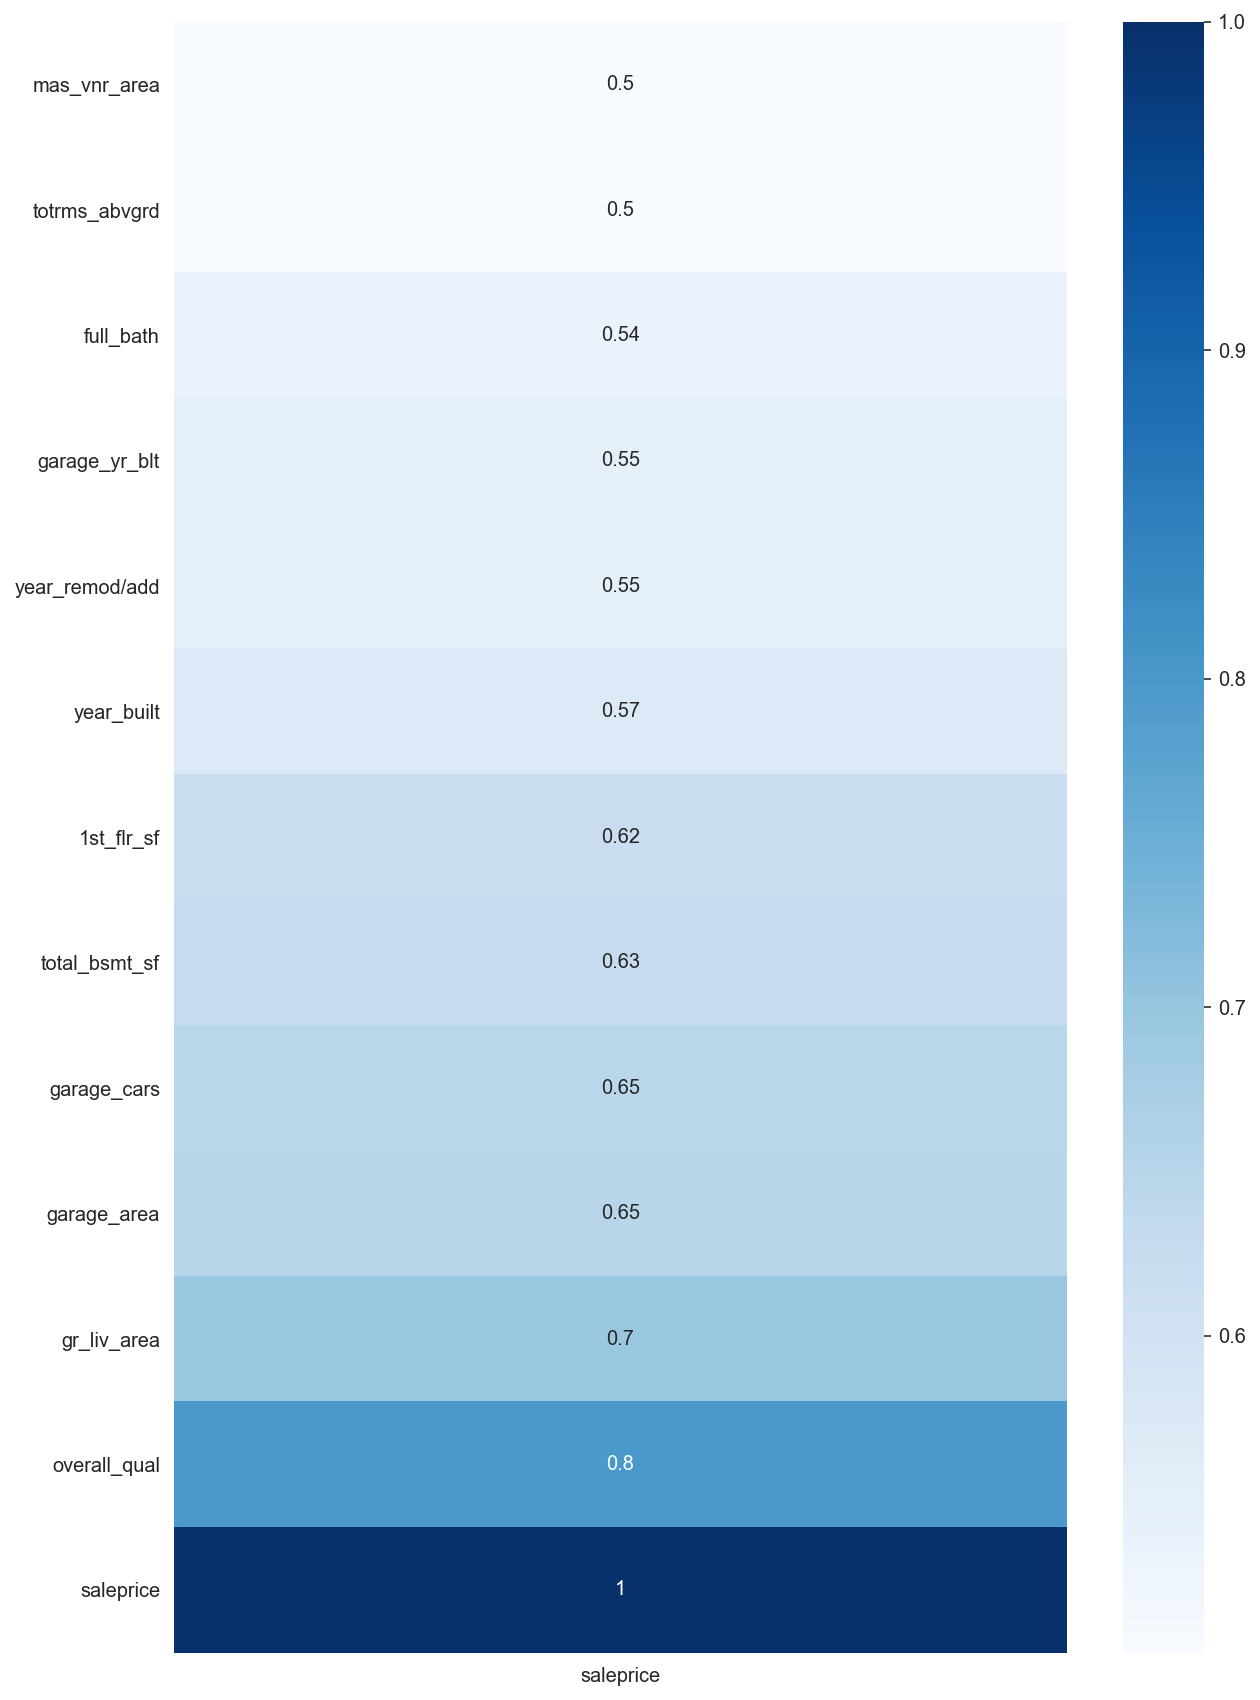

In [18]:
# visualizing the correlations with saleprice

plt.figure(figsize=(10,15))
sns.heatmap(correlation_s1, annot=True, cmap='Blues')

In [19]:
# first selection of independant variables

high_corr_var = ['mas_vnr_area',
 'totrms_abvgrd',
 'full_bath',
 'garage_yr_blt',
 'year_remod/add',
 'year_built',
 '1st_flr_sf',
 'total_bsmt_sf',
 'garage_cars',
 'garage_area',
 'gr_liv_area',
 'overall_qual',
 'saleprice']

In [20]:
# looking for multi-collinearity

correlation_s2 = correlation.loc[correlation['saleprice'] >= abs(0.50)]
train[high_corr_var].head()

,mas_vnr_area,totrms_abvgrd,full_bath,garage_yr_blt,year_remod/add,year_built,1st_flr_sf,total_bsmt_sf,garage_cars,garage_area,gr_liv_area,overall_qual,saleprice
0,289.0,6,2,1976.0,2005,1976,725,725.0,2.0,475.0,1479,6,130500
1,132.0,8,2,1997.0,1997,1996,913,913.0,2.0,559.0,2122,7,220000
2,0.0,5,1,1953.0,2007,1953,1057,1057.0,1.0,246.0,1057,5,109000
3,0.0,7,2,2007.0,2007,2006,744,384.0,2.0,400.0,1444,5,174000
4,0.0,6,2,1957.0,1993,1900,831,676.0,2.0,484.0,1445,6,138500


In [21]:
train_s1 = train[high_corr_var]

In [22]:
correlation_2 = train_s1.corr()

In [23]:
correlation_s2 = correlation_2.loc[correlation_2['saleprice'] >= abs(0.50)]
correlation_s2

,mas_vnr_area,totrms_abvgrd,full_bath,garage_yr_blt,year_remod/add,year_built,1st_flr_sf,total_bsmt_sf,garage_cars,garage_area,gr_liv_area,overall_qual,saleprice
mas_vnr_area,1.000000,0.271657,0.232474,0.267456,0.204234,0.320780,0.386482,0.403618,0.356709,0.380404,0.383875,0.430041,0.503579
totrms_abvgrd,0.271657,1.000000,0.519630,0.154809,0.202397,0.137783,0.393254,0.294787,0.368073,0.341137,0.813333,0.382025,0.504014
full_bath,0.232474,0.519630,1.000000,0.469950,0.471555,0.480169,0.367623,0.326277,0.466924,0.398203,0.617323,0.515080,0.537969
garage_yr_blt,0.267456,0.154809,0.469950,1.000000,0.642587,0.846610,0.289762,0.367316,0.607956,0.587149,0.276904,0.581284,0.550324
year_remod/add,0.204234,0.202397,0.471555,0.642587,1.000000,0.629116,0.244190,0.309795,0.441283,0.398951,0.322407,0.584654,0.550370
year_built,0.320780,0.137783,0.480169,0.846610,0.629116,1.000000,0.323315,0.410605,0.542862,0.486867,0.258838,0.602964,0.571849
1st_flr_sf,0.386482,0.393254,0.367623,0.289762,0.244190,0.323315,1.000000,0.808351,0.439115,0.498674,0.562441,0.477136,0.618486
total_bsmt_sf,0.403618,0.294787,0.326277,0.367316,0.309795,0.410605,0.808351,1.000000,0.433540,0.489055,0.454245,0.549407,0.629303
garage_cars,0.356709,0.368073,0.466924,0.607956,0.441283,0.542862,0.439115,0.433540,1.000000,0.892956,0.486101,0.587575,0.648225
garage_area,0.380404,0.341137,0.398203,0.587149,0.398951,0.486867,0.498674,0.489055,0.892956,1.000000,0.490897,0.563731,0.650246


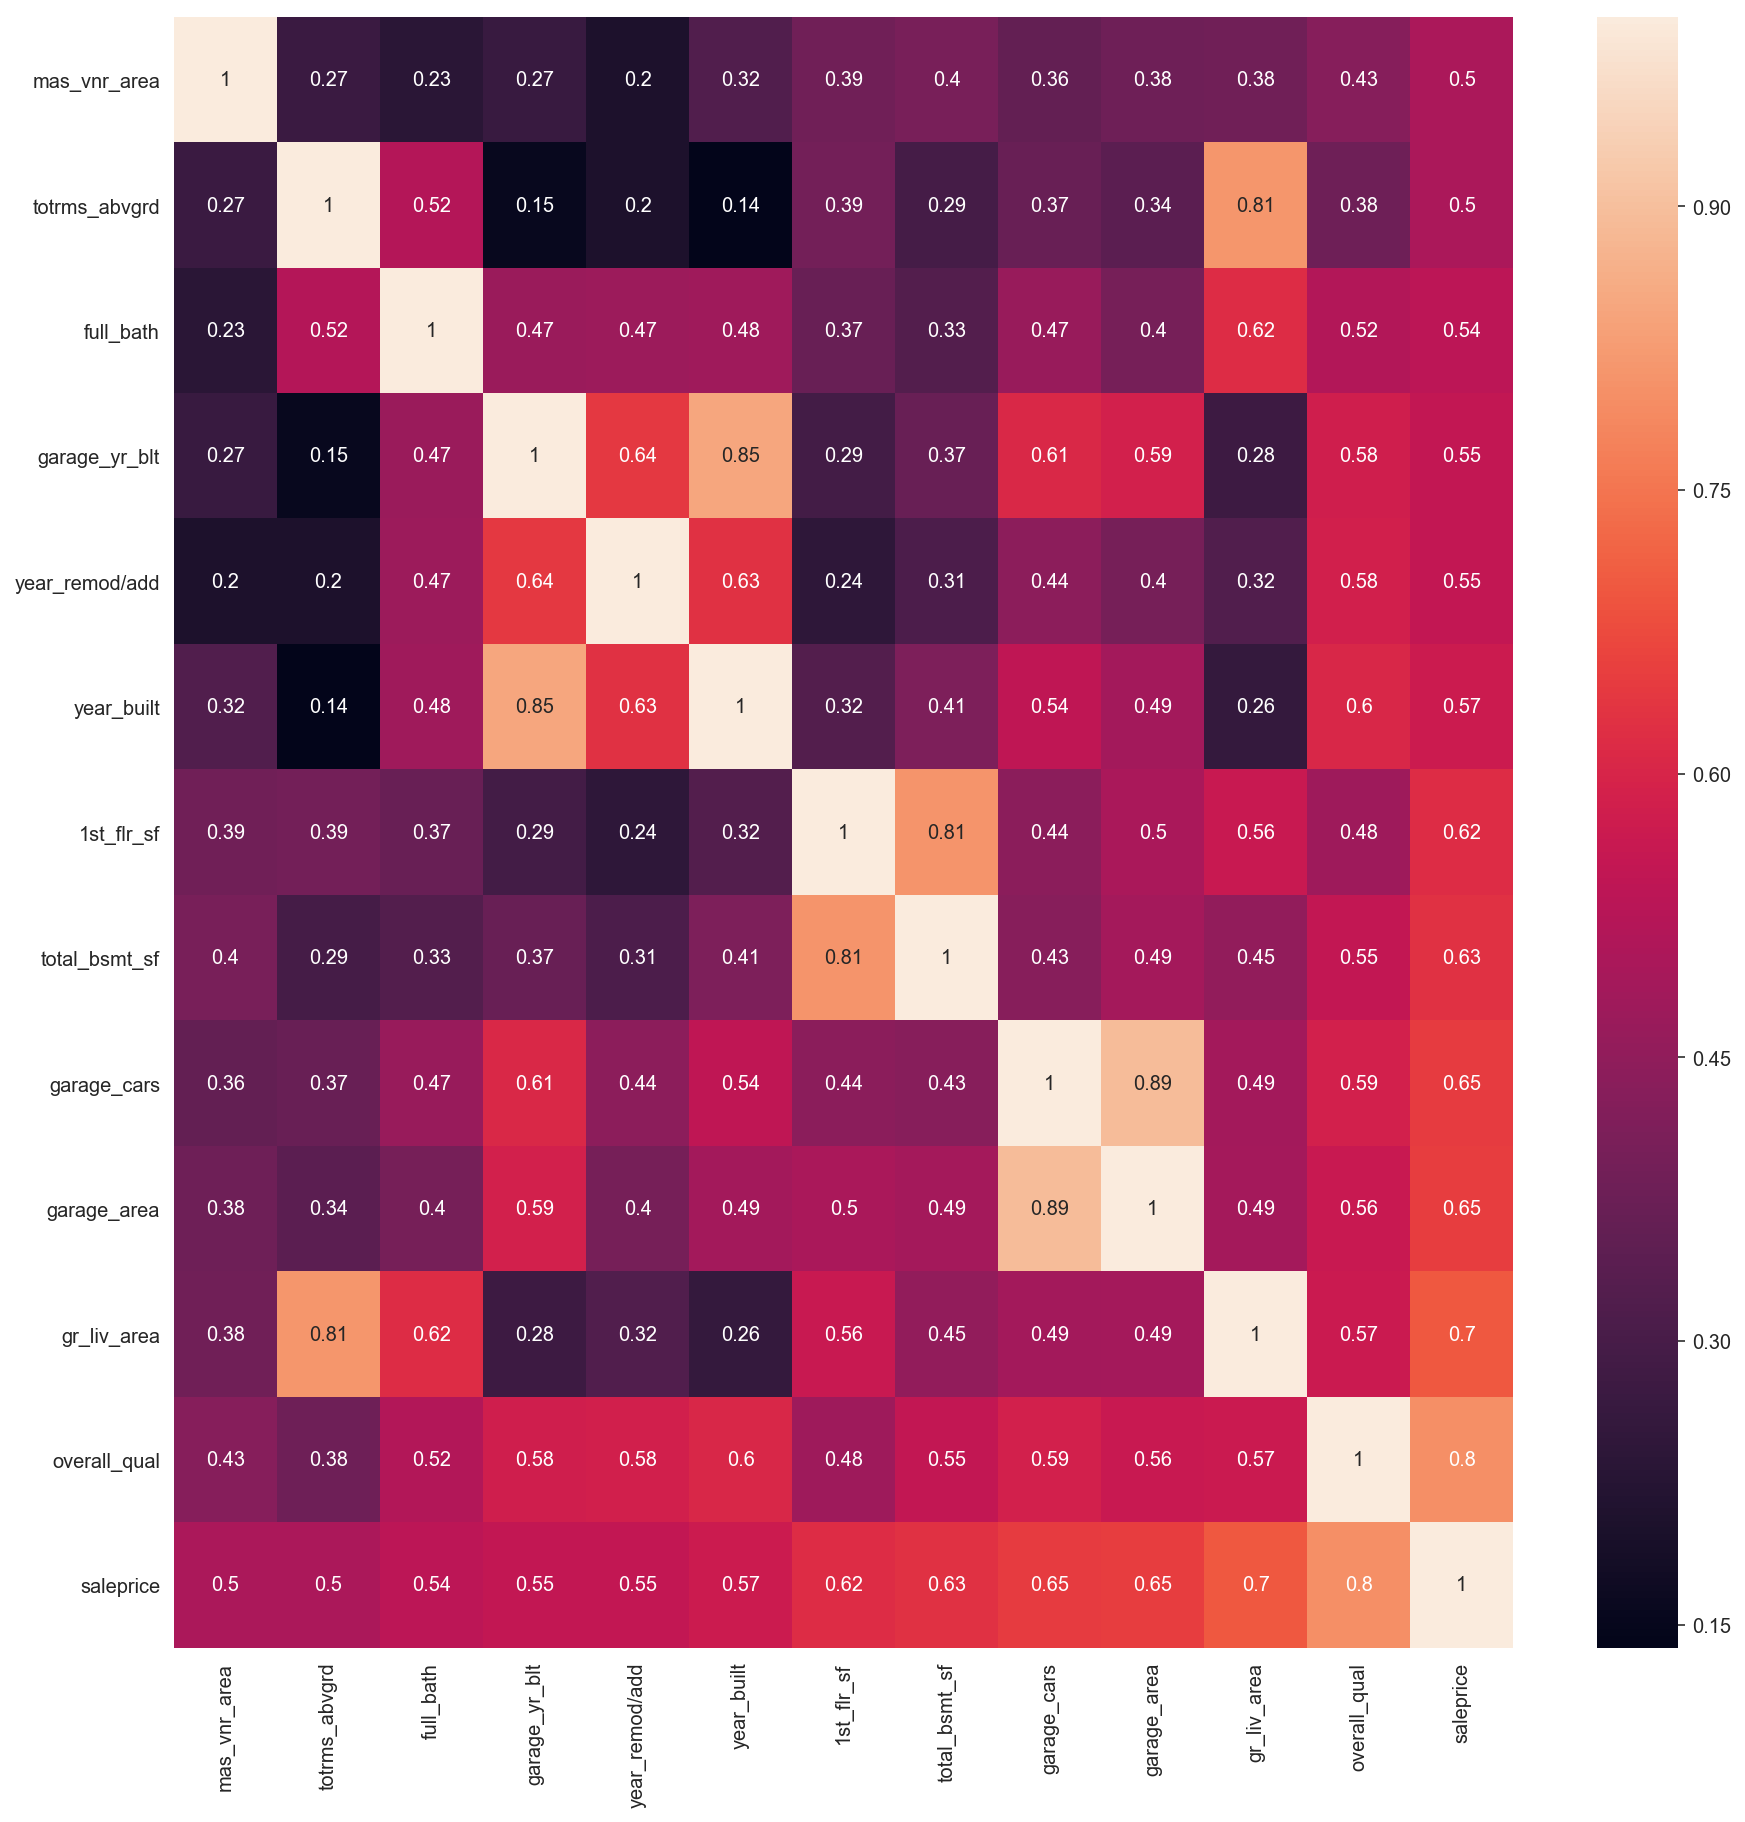

In [24]:
# looking at multi-collinearity

plt.figure(figsize=(15,15))
sns.heatmap(train_s1.corr(), annot=True)

In [25]:
# dropping multi-collinear features

high_corr_var = ['mas_vnr_area',
 'full_bath',
 'year_remod/add',
 'year_built',
 'total_bsmt_sf',
 'garage_area',
 'gr_liv_area',
 'overall_qual',
 'saleprice']

In [26]:
train[high_corr_var].head()

,mas_vnr_area,full_bath,year_remod/add,year_built,total_bsmt_sf,garage_area,gr_liv_area,overall_qual,saleprice
0,289.0,2,2005,1976,725.0,475.0,1479,6,130500
1,132.0,2,1997,1996,913.0,559.0,2122,7,220000
2,0.0,1,2007,1953,1057.0,246.0,1057,5,109000
3,0.0,2,2007,2006,384.0,400.0,1444,5,174000
4,0.0,2,1993,1900,676.0,484.0,1445,6,138500


In [27]:
train_s1 = train[high_corr_var]

In [28]:
dummy_columns = train_s1.select_dtypes(include = ['object'])

In [29]:
dummy_columns.columns

Index([], dtype='object')

## Pair plots

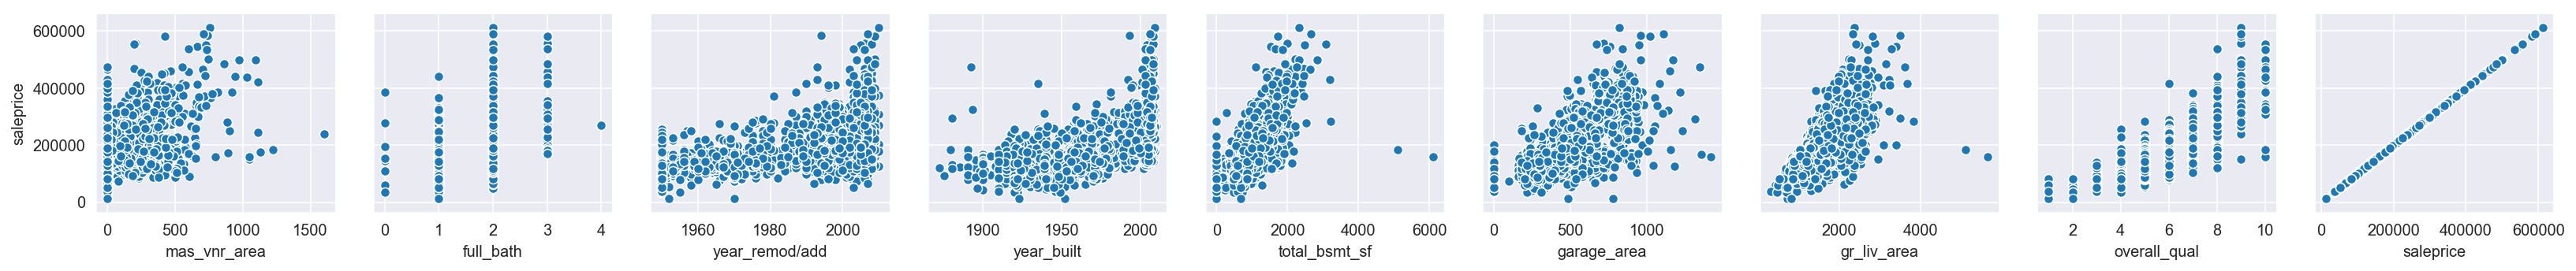

In [30]:
sns.pairplot(train, x_vars= high_corr_var, y_vars=['saleprice'])

## Create our features matrix (`X`) and target vector (`y`)

In [31]:
features = [col for col in train_s1.columns if col != 'saleprice']

In [32]:
X = train_s1[features]
y = train_s1['saleprice']

### Using Polynomial for features interaction

In [33]:
poly = PolynomialFeatures(include_bias = False)
X_poly = poly.fit_transform(X)
poly.get_feature_names(features)

['mas_vnr_area',
 'full_bath',
 'year_remod/add',
 'year_built',
 'total_bsmt_sf',
 'garage_area',
 'gr_liv_area',
 'overall_qual',
 'mas_vnr_area^2',
 'mas_vnr_area full_bath',
 'mas_vnr_area year_remod/add',
 'mas_vnr_area year_built',
 'mas_vnr_area total_bsmt_sf',
 'mas_vnr_area garage_area',
 'mas_vnr_area gr_liv_area',
 'mas_vnr_area overall_qual',
 'full_bath^2',
 'full_bath year_remod/add',
 'full_bath year_built',
 'full_bath total_bsmt_sf',
 'full_bath garage_area',
 'full_bath gr_liv_area',
 'full_bath overall_qual',
 'year_remod/add^2',
 'year_remod/add year_built',
 'year_remod/add total_bsmt_sf',
 'year_remod/add garage_area',
 'year_remod/add gr_liv_area',
 'year_remod/add overall_qual',
 'year_built^2',
 'year_built total_bsmt_sf',
 'year_built garage_area',
 'year_built gr_liv_area',
 'year_built overall_qual',
 'total_bsmt_sf^2',
 'total_bsmt_sf garage_area',
 'total_bsmt_sf gr_liv_area',
 'total_bsmt_sf overall_qual',
 'garage_area^2',
 'garage_area gr_liv_area',
 'g

In [34]:
train_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features)).head()

In [35]:
poly_features = ['mas_vnr_area',
 'full_bath',
 'year_remod/add',
 'year_built',
 'total_bsmt_sf',
 'garage_area',
 'gr_liv_area',
 'overall_qual',
 'mas_vnr_area^2',
 'mas_vnr_area full_bath',
 'mas_vnr_area year_remod/add',
 'mas_vnr_area year_built',
 'mas_vnr_area total_bsmt_sf',
 'mas_vnr_area garage_area',
 'mas_vnr_area gr_liv_area',
 'mas_vnr_area overall_qual',
 'full_bath^2',
 'full_bath year_remod/add',
 'full_bath year_built',
 'full_bath total_bsmt_sf',
 'full_bath garage_area',
 'full_bath gr_liv_area',
 'full_bath overall_qual',
 'year_remod/add^2',
 'year_remod/add year_built',
 'year_remod/add total_bsmt_sf',
 'year_remod/add garage_area',
 'year_remod/add gr_liv_area',
 'year_remod/add overall_qual',
 'year_built^2',
 'year_built total_bsmt_sf',
 'year_built garage_area',
 'year_built gr_liv_area',
 'year_built overall_qual',
 'total_bsmt_sf^2',
 'total_bsmt_sf garage_area',
 'total_bsmt_sf gr_liv_area',
 'total_bsmt_sf overall_qual',
 'garage_area^2',
 'garage_area gr_liv_area',
 'garage_area overall_qual',
 'gr_liv_area^2',
 'gr_liv_area overall_qual',
 'overall_qual^2']

## Train/test split


In [36]:
X_poly, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)

## Scaling

In [37]:
ss = StandardScaler()
ss.fit(X_poly)
X_poly = ss.transform(X_poly)
X_test = ss.transform(X_test);

## Instantiate the models

In [38]:
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

## Cross validation

In [39]:
lr_scores = cross_val_score(lr, X_poly, y_train, cv=5)
lr_scores.mean()

0.8569397585884408

In [40]:
lasso_scores = cross_val_score(lasso, X_poly, y_train, cv=5)
lasso_scores.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The de

0.752978234112818

In [41]:
ridge_scores = cross_val_score(ridge, X_poly, y_train, cv=5)
ridge_scores.mean()

0.8553378627718777

Models scores are close. Ridge is slightly higher.  

In [42]:
# fit the model to the training data
ridge.fit(X_poly, y_train);

# evaluate the training and test scores

In [43]:
ridge.score(X_poly, y_train)

0.8807752159897855

In [44]:
ridge.score(X_test, y_test)

0.8814502087442088

In [45]:
train_preds = ridge.predict(X_test)

In [46]:
plot_poly = pd.DataFrame({'predicted prices': train_preds, 'actual prices': y_test})

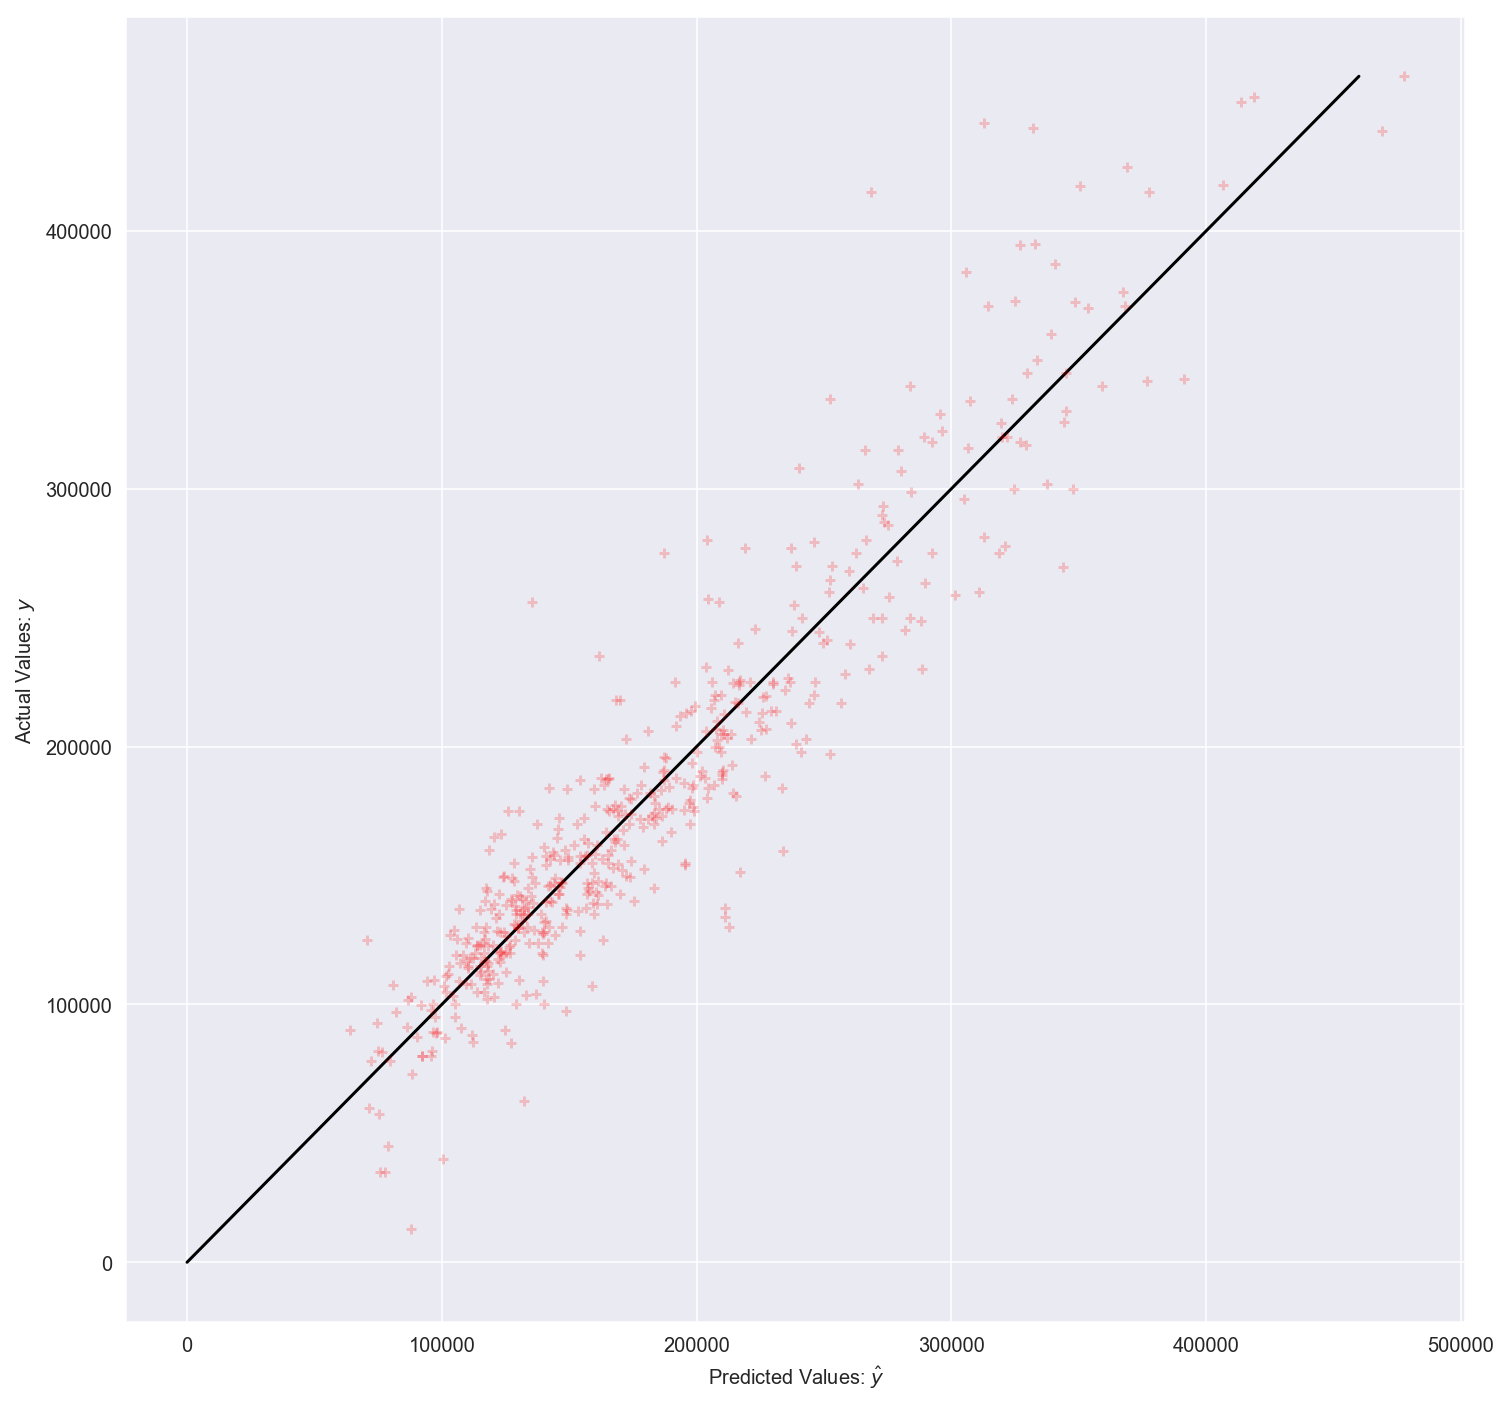

In [47]:
# Plot the model
plt.figure(figsize=(12,12))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(plot_poly['predicted prices'], plot_poly['actual prices'], s=30, c='r', marker='+', zorder=10, alpha = 0.2)
plt.xlabel("Predicted Values: $\hat{y}$")
plt.ylabel("Actual Values: $y$")

plt.plot([0, np.max(plot_poly['actual prices'])], [0, np.max(plot_poly['actual prices'])], c = 'k')

plt.show();

the model shows less of a predictive power starting a the high 300k's and plus.

In [48]:
#look at the coefficients
ridge.intercept_, ridge.coef_

(181061.99349804968,
 array([ -22221.48265342, -155153.39036321,  -51538.04674858,
          86952.26020482,    2557.82788954,  -38043.54488161,
        -114615.62312537,  -49276.19974192,   -1797.74356514,
          14118.57770256,   39480.60351759,  -23548.5965969 ,
           -543.30642639,   13953.13114329,  -14685.41801962,
          -1086.82881686,    6712.85465607,   86271.81788098,
          61843.54821607,    9473.08845816,  -13081.95493012,
          40959.11458819,  -34312.91117216,   44249.01152345,
          18268.36636482,   30008.08510993,   59472.00120581,
          84614.41694498,   37786.90365846,  -93417.48491293,
         -39686.74622411,  -15464.45555219,   27300.30419978,
          -5222.91297471,  -24615.40337864,     430.45429031,
         -41571.39351755,   80916.58081643,   -4249.95685631,
          15483.86800202,    3492.46511694,  -41148.7889654 ,
          90739.29872783,  -12674.97662205]))

In [49]:
import statsmodels.api as sm
model = sm.OLS(y_test, train_preds)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.729e+04
Date:                Sun, 24 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:53:24   Log-Likelihood:                -5961.9
No. Observations:                 513   AIC:                         1.193e+04
Df Residuals:                     512   BIC:                         1.193e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0016      0.006    165.189      0.000       0.990       1.014
==============================================================================
Omnibus:                       99.328   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.131
Skew:                           0.808   Prob(JB):                     2.37e-89
Kurtosis:                       7.060   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The above summary shows a strong R2 and a low p-value indicating a strong predictive power of the model.

# Test data

In [50]:
test = pd.read_csv('./datasets/test.csv')
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [51]:
test.columns = test.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [52]:
test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [53]:
def fill_continuous_mean(df, column_name):
    return df[column_name].fillna(df[column_name].mean(), inplace = True)

fill_continuous_mean(test, 'lot_frontage')
fill_continuous_mean(test,'garage_area')

In [54]:
def fill_nominal_NA(df, column_name):
    return df[column_name].fillna("NA", inplace = True)

fill_nominal_NA(test,'alley')
fill_nominal_NA(test,'garage_type')

In [55]:
def fill_nominal_None(df, column_name):
    return df[column_name].fillna("None", inplace = True)

fill_nominal_None(test, 'mas_vnr_type') #22 missing values
fill_nominal_None(test, 'misc_feature') #1986 missing values

In [56]:
def fill_continuous_zero(df, column_name):
    return df[column_name].fillna(0, inplace = True)

fill_continuous_zero(test, 'mas_vnr_area')
fill_continuous_zero(test, 'bsmtfin_sf_1')
fill_continuous_zero(test, 'bsmtfin_sf_2')
fill_continuous_zero(test, 'bsmt_unf_sf')
fill_continuous_zero(test, 'total_bsmt_sf')

In [57]:
def fill_ordinal_NA(df, column_name):
    return df[column_name].fillna('NA', inplace = True)

fill_ordinal_NA(test, 'fireplace_qu')
fill_ordinal_NA(test, 'garage_finish')
fill_ordinal_NA(test,'garage_qual')
fill_ordinal_NA(test,'garage_cond')
fill_ordinal_NA(test,'pool_qc')
fill_ordinal_NA(test,'fence')
fill_ordinal_NA(test,'bsmt_qual')
fill_ordinal_NA(test,'bsmt_cond')
fill_ordinal_NA(test,'bsmt_exposure')
fill_ordinal_NA(test,'bsmtfin_type_1')
fill_ordinal_NA(test,'bsmtfin_type_2')

In [58]:
def fill_same_year(df, column_name, same):
    return df[column_name].fillna(df[same], inplace = True)

fill_same_year(test, 'garage_yr_blt', 'year_built' )

In [59]:
def fill_discrete_mode1(df, column_name):
    return df[column_name].fillna(1, inplace = True)

fill_discrete_mode1(test,'garage_cars')
fill_discrete_mode1(test,'bsmt_full_bath')
fill_discrete_mode1(test,'bsmt_half_bath')

In [60]:
test.isnull().sum().sum()

1

In [61]:
test['electrical'].value_counts()

SBrkr    814
FuseA     48
FuseF     15
FuseP      1
Name: electrical, dtype: int64

In [62]:
test['electrical'].fillna('SBrkr', inplace = True)

In [63]:
test_poly = train_poly[poly_features]

In [64]:
test_columns= test_poly.select_dtypes(include = ['object'])
test_columns.columns

Index([], dtype='object')

In [65]:
test_poly.shape

(5, 44)

In [66]:
train_poly.shape

(5, 44)

### Applying the chosen model on the Test data

In [67]:
features_test = [col for col in test_poly.columns if col != 'saleprice']

In [68]:
poly_test = PolynomialFeatures(include_bias = False)
X_test_ac = test[features]
X_test_poly = poly_test.fit_transform(X_test_ac)
poly_test.get_feature_names(features_test)

['mas_vnr_area',
 'full_bath',
 'year_remod/add',
 'year_built',
 'total_bsmt_sf',
 'garage_area',
 'gr_liv_area',
 'overall_qual',
 'mas_vnr_area^2',
 'mas_vnr_area full_bath',
 'mas_vnr_area year_remod/add',
 'mas_vnr_area year_built',
 'mas_vnr_area total_bsmt_sf',
 'mas_vnr_area garage_area',
 'mas_vnr_area gr_liv_area',
 'mas_vnr_area overall_qual',
 'full_bath^2',
 'full_bath year_remod/add',
 'full_bath year_built',
 'full_bath total_bsmt_sf',
 'full_bath garage_area',
 'full_bath gr_liv_area',
 'full_bath overall_qual',
 'year_remod/add^2',
 'year_remod/add year_built',
 'year_remod/add total_bsmt_sf',
 'year_remod/add garage_area',
 'year_remod/add gr_liv_area',
 'year_remod/add overall_qual',
 'year_built^2',
 'year_built total_bsmt_sf',
 'year_built garage_area',
 'year_built gr_liv_area',
 'year_built overall_qual',
 'total_bsmt_sf^2',
 'total_bsmt_sf garage_area',
 'total_bsmt_sf gr_liv_area',
 'total_bsmt_sf overall_qual',
 'garage_area^2',
 'garage_area gr_liv_area',
 'g

In [69]:
X_test_poly_sc = ss.transform(X_test_poly)

In [70]:
test_preds = ridge.predict(X_test_poly_sc)

In [71]:
test['saleprice'] = test_preds

In [72]:
submit_9 = test[['id','saleprice']]

In [73]:
submit_9.to_csv('submit_9.csv',index=False)